In [1]:
# Импорт библиотек

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image
import tensorflow as tf


# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)



In [3]:
# Берем датасэт с котами и собаками

In [4]:
import tensorflow_datasets as tfds

In [5]:
ds_names = ( 'oxford_iiit_pet:3.*.*',)
dataset_all, info = tfds.load(ds_names[0], split = ['train[:10%]','test[-10%:]'], with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteELHZRY/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteELHZRY/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [6]:
# Смотрим что там лежит

In [7]:
type(dataset_all)

list

In [8]:
dataset_all[0]

<PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>

In [9]:
dataset_all[1]

<PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>

In [11]:
try:
    dataset_all[2]
except:
    print('lol')

lol


In [12]:
# что это за тип данных? На уроке есть куча функций который работают с ним.

In [13]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [14]:
# 1? def normalize принимет картинку и маску картинки. Трансформирует картинку в тензор?
# 2? Какой тип данных у картинки? И почему его именно в этот тип обратили?
# 3? Что такое маска картинки и зачем от нее отнимать -1?

In [15]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [16]:
# Ответ на свой вопрос 2 dataset_all похож на словарь? , проверка

In [18]:
try:
    dataset_all[0]['image']
except:
    print('lol') # фиаско

lol


In [23]:
# tf.random.uniform(())
# 4? Зачем в условия ставить случайный генератор? - Для того чтобы у некоторых картнинок поменять порядок пикселей? Если так то для чего?@tf.function
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask


In [24]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 16
BUFFER_SIZE = 128
STEPS_PER_EPOCH = TRAIN_LENGTH // 10 // BATCH_SIZE

In [27]:
# 5? Что делает BUFFER_SIZE?

In [28]:
train = dataset_all[0].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset_all[1].map(load_image_test)

In [32]:
# for i in dataset_all[0]:
#     print(i)
# 2? Получается мы берем какой итерируемый тип данных, типо генератора какого-то и проходимся по ниму функциями load_image_train, num_parallel_calls

In [33]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)
# 7? .cache() типо как обнуляет наш генератор который уже все закончился? 
# Далее перемешиваем при помощи shuffle все кусками по 128 элементов?
# Далее этот список делим на куски по 128 элементов?
# repeat()? что это за повтарение?
# prefetch(buffer_size=tf.data.experimental.AUTOTUNE) - что это делает? Вроде как кокой то контроль над чем то дает?

In [34]:
# Функция для отлова кошечек и собачек

In [35]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

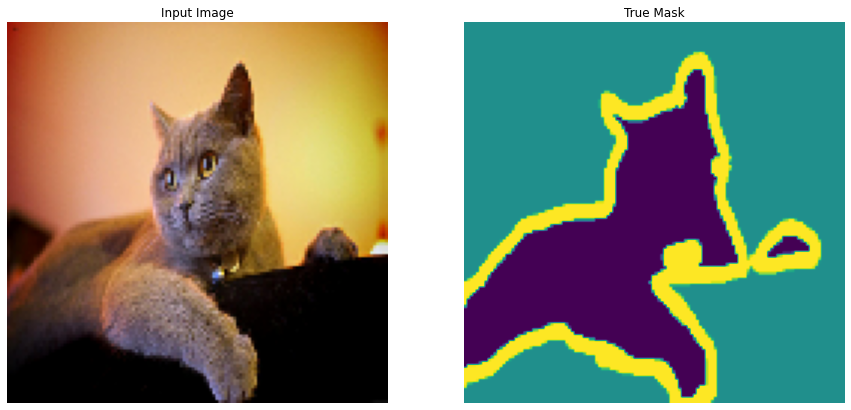

In [36]:
for image, mask in test_dataset.take(1):
  sample_image, sample_mask = image, mask
display([sample_image[0,:,:,:], sample_mask[0,:,:,:]])

In [37]:
# 2？ .take(1) - вот так можно обращаться к элементам данного типа данных. ок.

In [39]:
sample_image.shape 
# Элемент это 16 матриц, в который по 128 матриц, в который по 128 строк и 3 столбца?

TensorShape([16, 128, 128, 3])

In [45]:
OUTPUT_CHANNELS = 3

In [46]:
# 8? Три лейбла на пиксель - обьект, граница, фон?

In [47]:
# Я так понял, что писать ручками модель, не надо. Что мы можем уже брать модели с весами
# Хотя тоже скорее всего попробую взять unet из урок_6_Сегментация 04_06_21 и затестить

In [48]:
# 9? Это значить модель с весами.
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Активационные функции для наших слоев, тут вроде все понятно
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

# 10? Здесь .output - это мы берем веса ? То есть маски признаков ?
layers = [base_model.get_layer(name).output for name in layer_names]

# Модель с входными слоями
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

# Эту часть сети не обучаем
down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [56]:
!pip install git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-s8x3thyt
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-s8x3thyt
  Created wheel for tensorflow-examples: filename=tensorflow_examples-55fcbdbe8578e7fa585c2a83d557cf759fa19d0f_-py3-none-any.whl size=270996 sha256=9f11c6643974680181277dde1e6efbf92d62b6daee6fbfeeb5fd5de58ffc3f13
  Stored in directory: /tmp/pip-ephem-wheel-cache-hr4o7_5z/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [57]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [70]:
# 11? Мы берем 512, 256, 128, 64 масок признаков и увеличивает кол-во весов при помощи Conv2DTranspose?

In [59]:
# модель с урока

def unet_model(output_channels):
  # Размер матриц принимаемых на вход  
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Матрицы которые мы получили на вход мы отдаем на сьедение первой части сети 
  skips = down_stack(x)
  # 12? Берем последний слой начльной части сети?
  x = skips[-1]
  # 13? Меняем слои местами кроме последнего который остался в х
  skips = reversed(skips[:-1])

  # 14? Объединяем верхние и нижние слои?
  for up, skip in zip(up_stack, skips):
    # 15? Берем верхний слой х передаем его в вернюю часть сети?
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    # 16? Обьединяем верхний слои и нижние перевернутые слои?
    x = concat([x, skip])

  # 17? ппоследний выходной слой?
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [60]:
# Cтроим модель

In [61]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

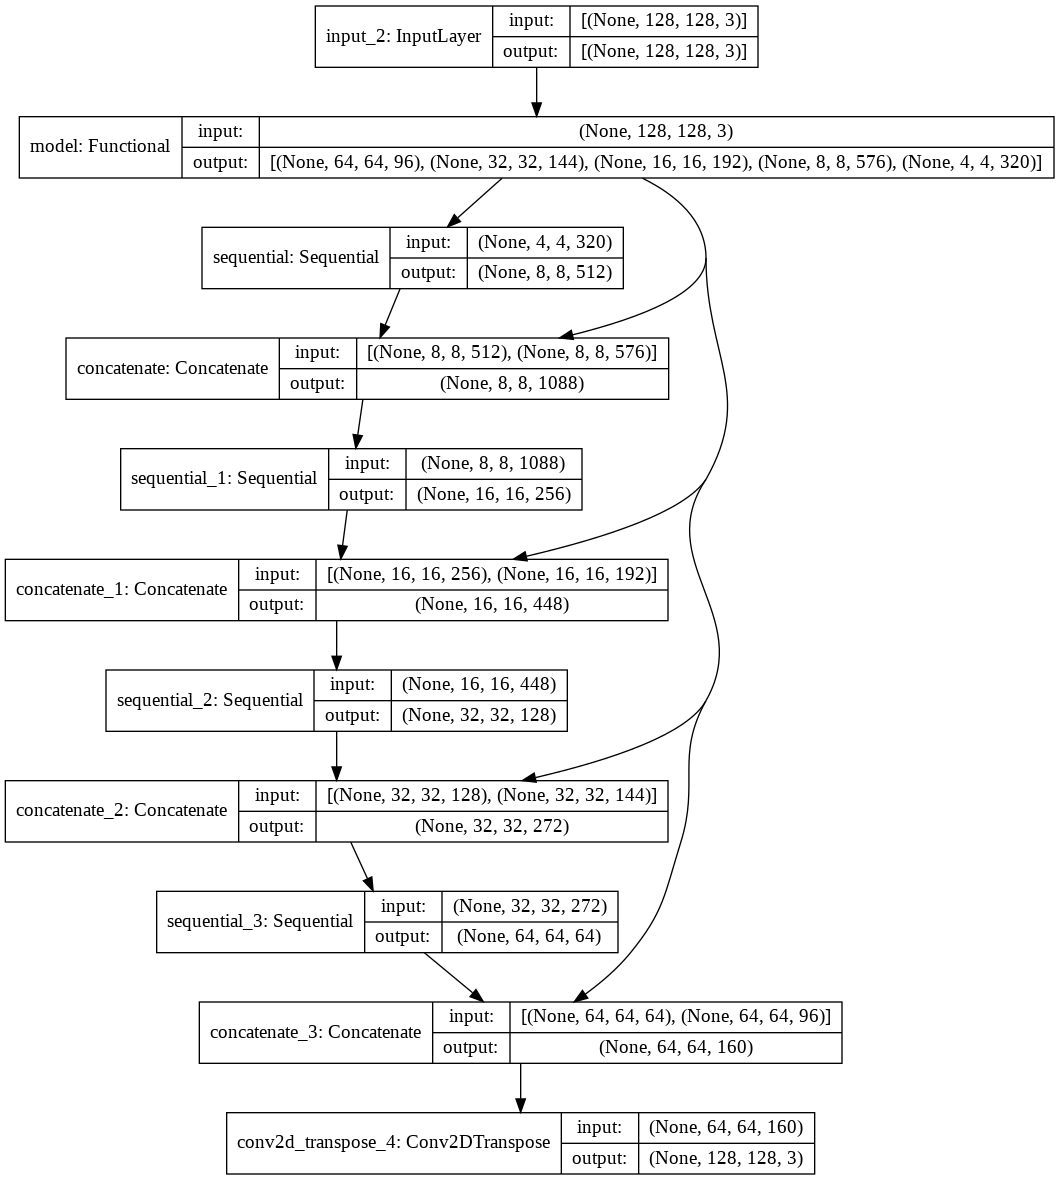

In [62]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Функции для создания маски

In [63]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]  # 18? что это за точки такие?
  return pred_mask[0]

In [64]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      print(1)
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image[0,:,:,:], sample_mask[0,:,:,:],
             create_mask(model.predict(sample_image[:,:,:]))])

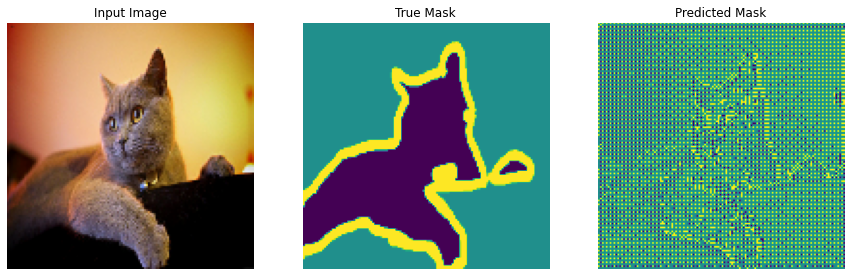

In [65]:
show_predictions()

In [66]:
# Создаем класс который будет показывать результат после обучения

In [67]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

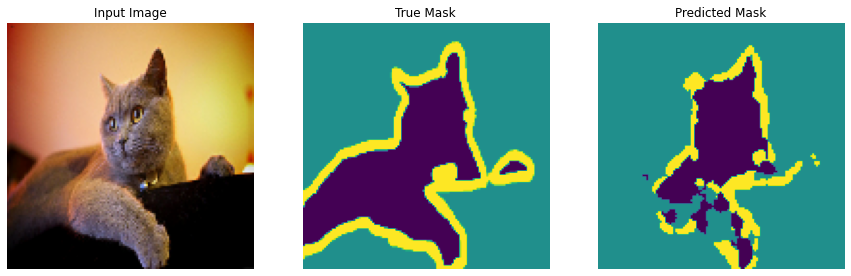


Sample Prediction after epoch 35



In [69]:
from IPython.display import clear_output
EPOCHS = 35 # увеличьте при необходимости

VAL_SUBSPLITS = 5

VALIDATION_STEPS = info.splits['test'].num_examples//10//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, 
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()]
                          )

1


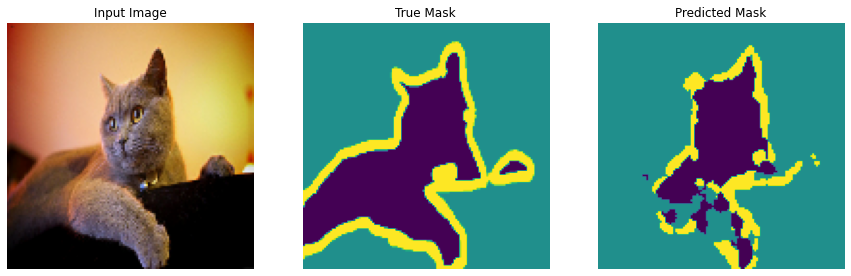

1


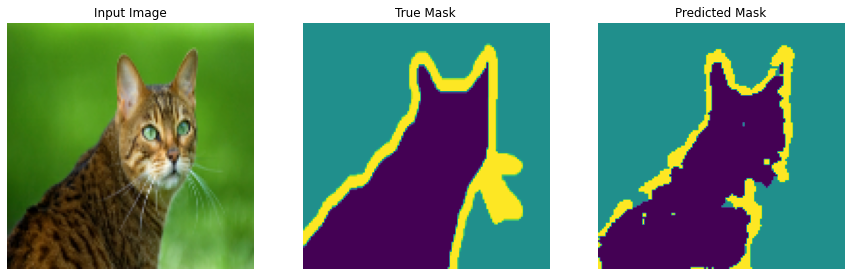

1


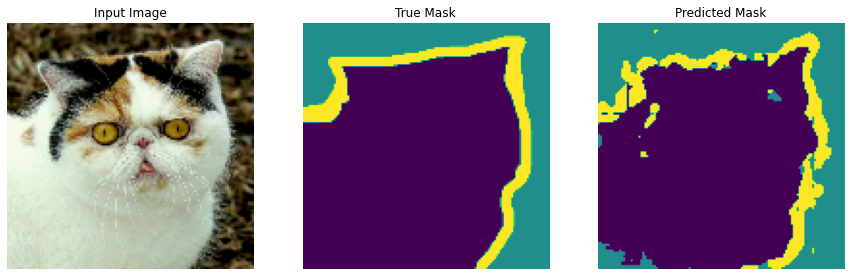

1


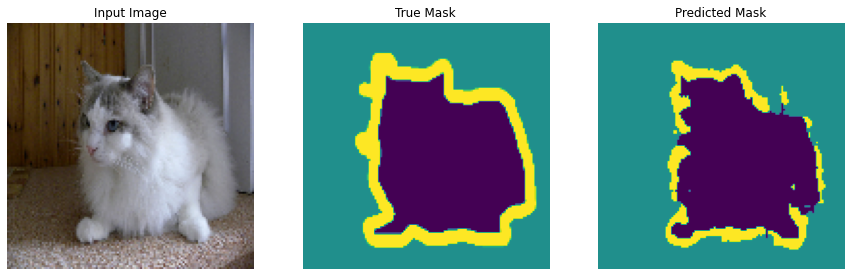

1


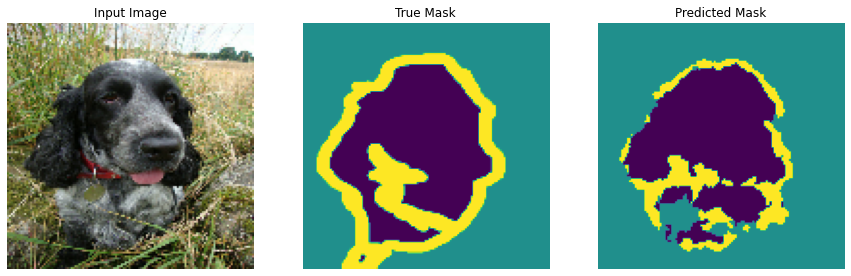

1


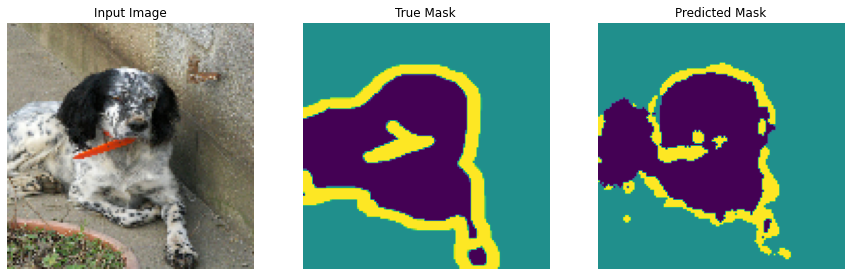

1


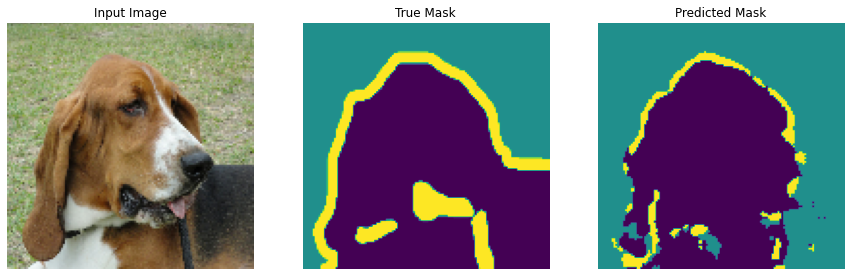

1


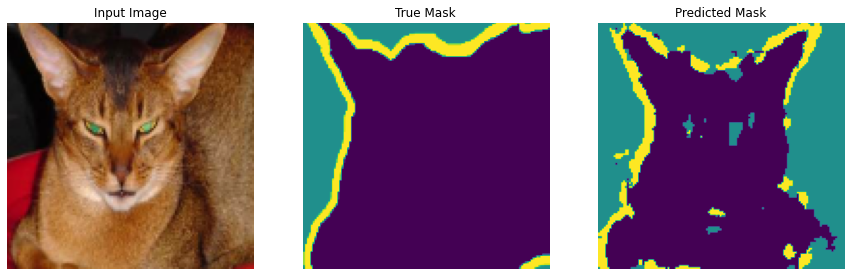

1


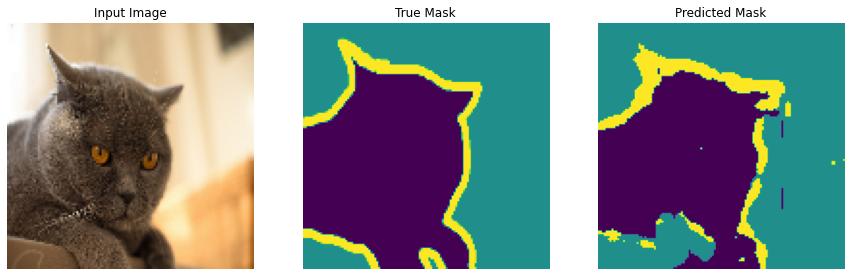

1


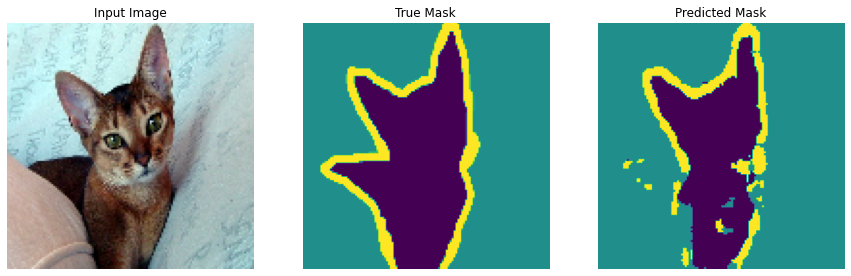

In [78]:
show_predictions(dataset=test_dataset, num=10)

# Вопросы и заключения по этой части:
# 1? def normalize принимет картинку и маску картинки. Трансформирует картинку в тензор?
# Мой ответ: Формируем тензоры элементов от 0 до 1. 
# 2? Какой тип данных у картинки? И почему его именно в этот тип обратили?
# Мой ответ: Тип данных типа генератор, который хранит в себе элетементы, которые можно достать методом .take(1).
# 3? Что такое маска картинки и зачем от нее отнимать -1?
# Мой ответ: это типо маска признаков класса.
# 4? Зачем в условия ставить случайный генератор? - Для того чтобы у некоторых картнинок поменять порядок пикселей? Если так то для чего? @tf.function
# Мой ответ: Генерация новых признаков?

# 5? Что делает BUFFER_SIZE?
# Мой ответ: размер кол-во элементов которые нужно перемешать?
# 6? num_parallel_calls - это типо паралельно можно делать?
# Мой ответ: кол-во паралельных вызовов?
# 7? .cache() типо как обнуляет наш генератор который уже все закончился? 
# Мой ответ: Судя по всему возвращает обьект в изначаельное состояние. При котором с ним возможна работа.
# 8? Три лейбла на пиксель - обьект, граница, фон?
# Мой ответ: обьект, граница, фон
# 9? Это значить модель с весами.
# Мой ответ: base_model - это модель в которой есть веса уже пред обучены.
# 10? Здесь .output - это мы берем веса ? То есть маски признаков ?
# Мой ответ: Мы берем веса предобученой модели,
# 11? Мы берем 512, 256, 128, 64 масок признаков и увеличивает кол-во весов при помощи Conv2DTranspose?
# Мой ответ: pic2pic трансформирует картинку, в нашем случае создаем доп признаки.
# 12? Берем последний слой начльной части сети?
# Мой ответ: +
# 13? Меняем слои местами кроме последнего который остался в х
# Мой ответ: +
# 14? Объединяем верхние и нижние слои?
# Мой ответ: скорее берем веса из нижней части сети и передаем ее в соответсвующую часть верхней сети
# 15? Берем верхний слой х передаем его в вернюю часть сети?
# Мой ответ: Прямое движение весов от слоя к слою.
# 16? Обьединяем верхний слои и нижние перевернутые слои?
# Мой ответ: Просто создаем полную сеть.
# 17? ппоследний выходной слой?
# Мой ответ: + 
# 18? что это за точки такие?
# Мой ответ: так и не понял...

In [82]:
# Часть 2
from tensorflow.keras.applications import VGG16

In [ ]:
# Берем модель из урок_6_Сегментация 04_06_21, меняем в ней
# input_shape =  , num_classes = 3
# loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [86]:
def bloc_transpose(x,block_out, numb_filter = [256,128]):
  x = concatenate([x, block_out])
  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 
  x = Conv2DTranspose(numb_filter[1], (2, 2), strides=(2, 2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [83]:
def unet_pre_train(num_classes = 3, input_shape= (128, 128, 3)):    
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

    # 19? Берем только 18 первых слоев модели pre_trained_model?
    for layer in pre_trained_model.layers[:18]:
      layer.trainable = False
    
    # 20? Получается мы знаем какие слои в этой сеточке выходные?
    
    x = pre_trained_model.layers[13].output # конец сверток
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output # первое уменьшение размера
    img_input = pre_trained_model.inputs
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
    # UP 1

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x, block_4_out, numb_filter = [256,128])
    

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x,block_3_out, numb_filter = [128,64])
    

    # UP 3
  

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x,block_2_out, numb_filter = [64,32])


    # UP 4
   
    
    #
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[dice_coef])
    model.summary()
    return model

In [87]:
model = unet_pre_train()

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_4[0][0]            

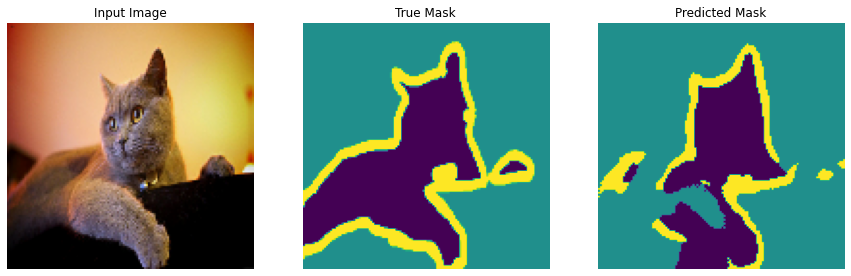


Sample Prediction after epoch 5



In [89]:
EPOCHS = 5 # увеличьте при необходимости

VAL_SUBSPLITS = 5

VALIDATION_STEPS = info.splits['test'].num_examples//10//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, 
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()]
                          )

In [90]:
# 21? При обучении этой сети я заметил, что она очень хорошо замечает граничный слой,
# но при этом за границу берет так-же слой внутренний. Есть ли интсрументы которые моглибы 
# который моглибы задать толщину слоя border равной n  пикселей, а все внутри закрасить цветом обьекта?


# 19? Берем только 18 первых слоев модели pre_trained_model?
# 20? Получается мы знаем какие слои в этой сеточке выходные?
# 21? При обучении этой сети я заметил, что она очень хорошо замечает граничный слой,
# но при этом за границу берет так-же слой внутренний. Есть ли интсрументы которые моглибы 
# который моглибы задать толщину слоя border равной n  пикселей, а все внутри закрасить цветом обьекта?


1


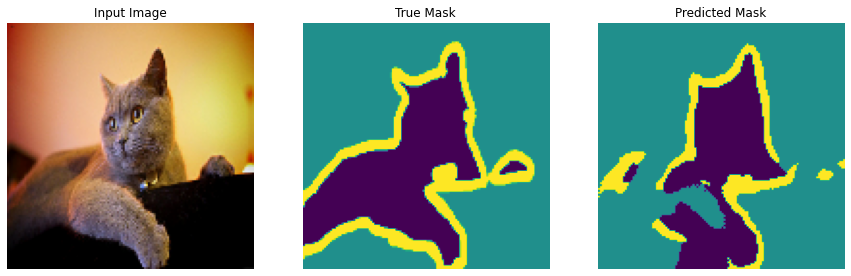

1


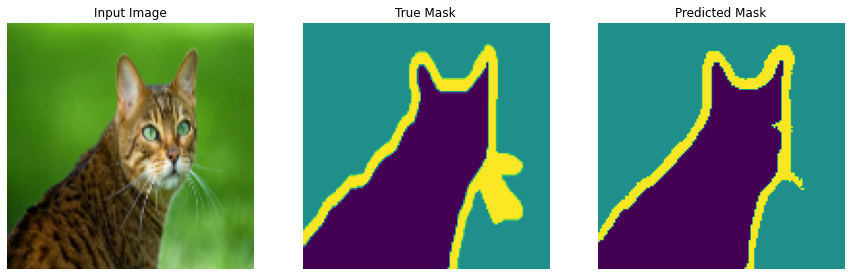

1


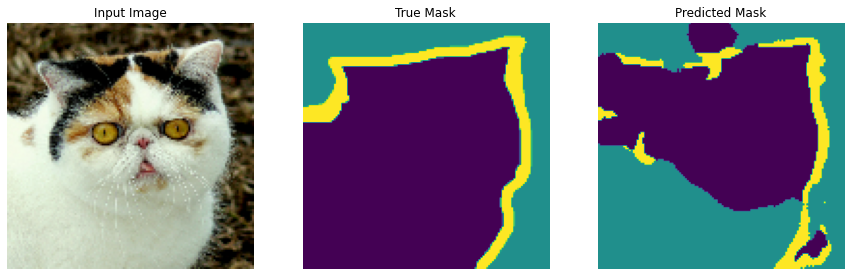

1


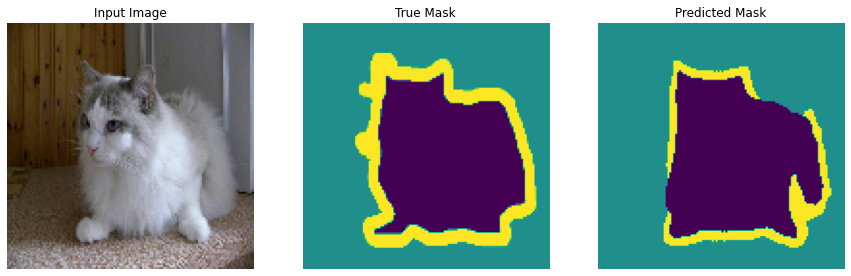

1


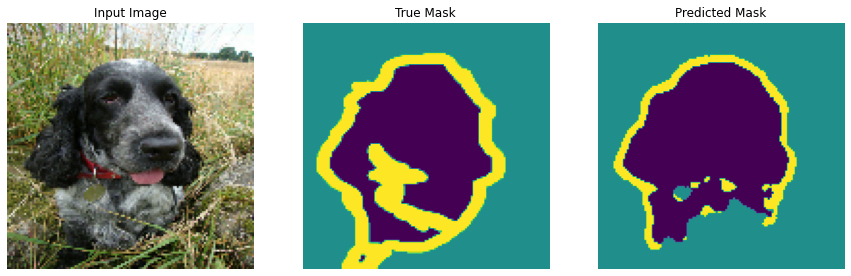

1


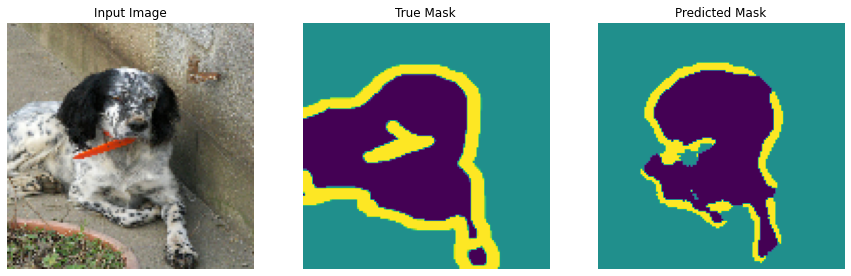

1


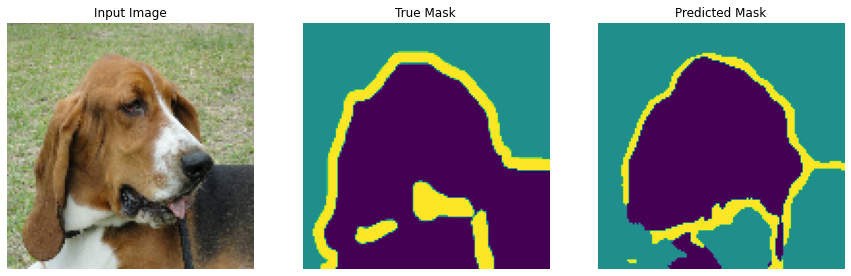

1


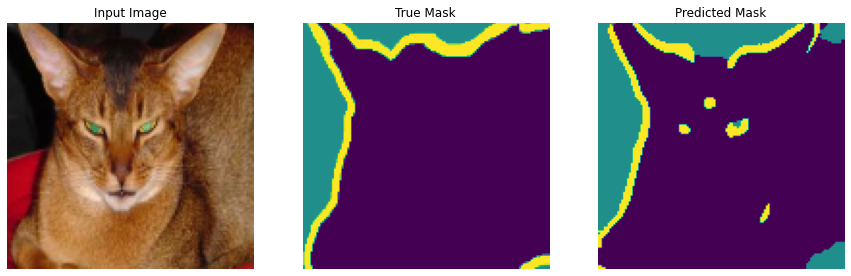

1


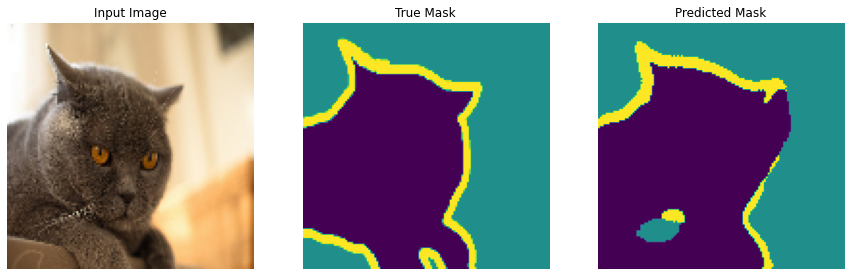

1


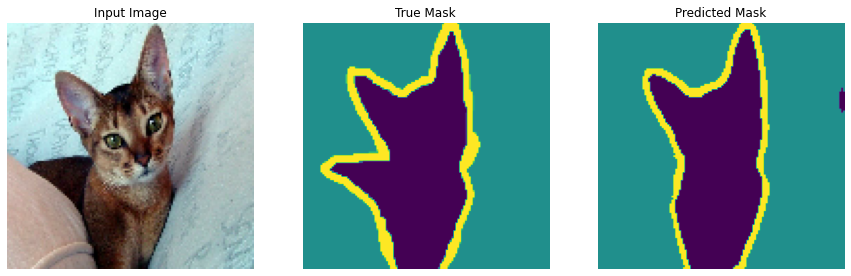

In [91]:
show_predictions(dataset=test_dataset, num=10)

Вывод: Сеть задает каждому пикселю принадлежность к "классу" обьект, граница, фон. То есть учиться отделять обьект от всего остального. У первой сети и второй сети, за основу взяты нейросети с готовыми весами, что заметно ускоряет процесс обучения. И в теории мы получаем готовый продукт за половину усилии. Учим мы только слои верхние, в которые из нижних слоев передаем маски признаков и линейно отработанные признаки сверток. Все это работает очень мило, первая сеть не плохо распознает основной обьект, а вторая на 1 эпохе практически идеально задает границы обьекта, но то что на самом деле обьект она тоже признает за границу. Звучит так как будто бы нужно просто сделать заливку внутри этой границы, но какие для этого сейчас есть ресурсы и есть ли?